# Fitting 2D images with Sherpa

## Introduction

Sherpa is the X-ray satellite Chandra modeling and fitting application. It enables the user to construct complex models from simple definitions and fit those models to data, using a variety of statistics and optimization methods. 
The issues of constraining the source position and morphology are common in X- and Gamma-ray astronomy. 
This notebook will show you how to apply Sherpa to CTA data.

Here we will set up Sherpa to fit the counts map and loading the ancillary images for subsequent use. A relevant test statistic for data with Poisson fluctuations is the one proposed by Cash (1979). The simplex (or Nelder-Mead) fitting algorithm is a good compromise between efficiency and robustness. The source fit is best performed in pixel coordinates.

## Read sky images
The sky image that are loaded here have been prepared in a separated notebook. Here we start from those fits file and focus on the source fitting aspect.

The info needed for sherpa are:
- Count map
- Background map
- Exposure map
- PSF map

For info, the fits file are written in the following way in the Sky map generation notebook:

```
images['counts']    .write("G300-0_test_counts.fits", clobber=True)
images['exposure']  .write("G300-0_test_exposure.fits", clobber=True)
images['background'].write("G300-0_test_background.fits", clobber=True)

##As psf is an array of quantities we cannot use the images['psf'].write() function
##all the other arrays do not have quantities. 
fits.writeto("G300-0_test_psf.fits",images['psf'].data.value,overwrite=True)
```


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from gammapy.maps import Map, WcsNDMap, WcsGeom

# Warnings about XSPEC or DS9 can be ignored here
import sherpa.astro.ui as sh

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [2]:
# Read the fits file to load them in a sherpa model
hdr = fits.getheader("G300-0_test_counts.fits")
wcs = WCS(hdr)

sh.set_stat("cash")
sh.set_method("simplex")
sh.load_image("G300-0_test_counts.fits")
sh.set_coord("logical")

sh.load_table_model("expo", "G300-0_test_exposure.fits")
sh.load_table_model("bkg", "G300-0_test_background.fits")
sh.load_psf("psf", "G300-0_test_psf.fits")

In principle one might first want to fit the background amplitude. However the background estimation method already yields the correct normalization, so we freeze the background amplitude to unity instead of adjusting it. The (smoothed) residuals from this background model are then computed and shown.

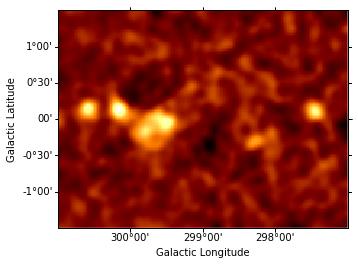

In [3]:
sh.set_full_model(bkg)
bkg.ampl = 1
sh.freeze(bkg)

resid = Map.read("G300-0_test_counts.fits")
resid.data = sh.get_data_image().y - sh.get_model_image().y
resid_smooth = resid.smooth(radius=6)
resid_smooth.plot();

### Find and fit the brightest source
We then find the position of the maximum in the (smoothed) residuals map, and fit a (symmetrical) Gaussian source with that initial position:

In [4]:
yp, xp = np.unravel_index(
    np.nanargmax(resid_smooth.data), resid_smooth.data.shape
)
ampl = resid_smooth.get_by_pix((xp, yp))[0]

sh.set_full_model(
    bkg + psf(sh.gauss2d.g0) * expo
)  # creates g0 as a gauss2d instance
g0.xpos, g0.ypos = xp, yp
sh.freeze(g0.xpos, g0.ypos)  # fix the position in the initial fitting step

expo.ampl = (
    1e-9
)  # fix exposure amplitude so that typical exposure is of order unity
sh.freeze(expo)
sh.thaw(g0.fwhm, g0.ampl)  # in case frozen in a previous iteration

g0.fwhm = 10  # give some reasonable initial values
g0.ampl = ampl

In [5]:
%%time
sh.fit()

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47907.2
Final fit statistic   = 47503 at function evaluation 234
Data points           = 30000
Degrees of freedom    = 29998
Change in statistic   = 404.211
   g0.fwhm        6.43418     
   g0.ampl        0.400131    
CPU times: user 1.66 s, sys: 32.7 ms, total: 1.69 s
Wall time: 1.69 s


Fit all parameters of this Gaussian component, fix them and re-compute the residuals map.

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47503
Final fit statistic   = 47498.4 at function evaluation 354
Data points           = 30000
Degrees of freedom    = 29996
Change in statistic   = 4.57486
   g0.fwhm        6.33581     
   g0.xpos        41.9218     
   g0.ypos        81.3048     
   g0.ampl        0.417545    


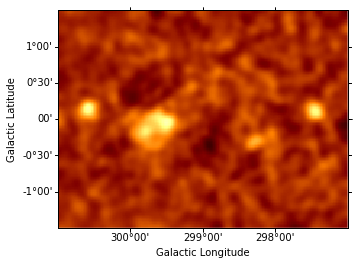

In [6]:
sh.thaw(g0.xpos, g0.ypos)
sh.fit()
sh.freeze(g0)

resid.data = sh.get_data_image().y - sh.get_model_image().y
resid_smooth = resid.smooth(radius=6)
resid_smooth.plot(vmin=-0.5, vmax=1);

### Iteratively find and fit additional sources
Instantiate additional Gaussian components, and use them to iteratively fit sources, repeating the steps performed above for component g0. (The residuals map is shown after each additional source included in the model.) This takes some time...

In [7]:
# initialize components with fixed, zero amplitude
for i in range(1, 6):
    model = sh.create_model_component("gauss2d", "g" + str(i))
    model.ampl = 0
    sh.freeze(model)

gs = [g0, g1, g2, g3, g4, g5]
sh.set_full_model(bkg + psf(g0 + g1 + g2 + g3 + g4 + g5) * expo)

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47648.5
Final fit statistic   = 47335 at function evaluation 219
Data points           = 30000
Degrees of freedom    = 29998
Change in statistic   = 313.452
   g1.fwhm        19.8613     
   g1.ampl        0.100529    
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47335
Final fit statistic   = 47293.7 at function evaluation 394
Data points           = 30000
Degrees of freedom    = 29996
Change in statistic   = 41.3431
   g1.fwhm        19.9265     
   g1.xpos        67.2544     
   g1.ypos        69.3013     
   g1.ampl        0.116012    
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47430.6
Final fit statistic   = 47185.5 at function evaluation 230
Data points           = 30000
Degrees of freedom    = 29998
Change in statistic   = 245.088

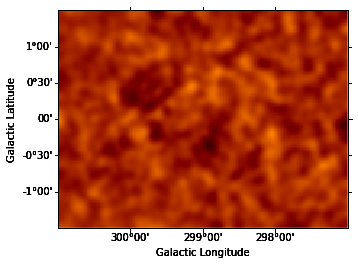

In [8]:
%%time
for i in range(1, len(gs)):
    yp, xp = np.unravel_index(
        np.nanargmax(resid_smooth.data), resid_smooth.data.shape
    )
    ampl = resid_smooth.get_by_pix((xp, yp))[0]
    gs[i].xpos, gs[i].ypos = xp, yp
    gs[i].fwhm = 10
    gs[i].ampl = ampl

    sh.thaw(gs[i].fwhm)
    sh.thaw(gs[i].ampl)
    sh.fit()

    sh.thaw(gs[i].xpos)
    sh.thaw(gs[i].ypos)
    sh.fit()
    sh.freeze(gs[i])

    resid.data = sh.get_data_image().y - sh.get_model_image().y
    resid_smooth = resid.smooth(radius=6)
    resid_smooth.plot(vmin=-0.5, vmax=1)

### Generating output table and Test Statistics estimation
When adding a new source, one need to check the significance of this new source. A frequently used method is the Test Statistics (TS). This is done by comparing the change of statistics when the source is included compared to the null hypothesis (no source ; in practice here we fix the amplitude to zero).

$TS = Cstat(source) - Cstat(no source)$

The criterion for a significant source detection is typically that it should improve the test statistic by at least 25 or 30. The last excess fitted (g5) thus not a significant source:

In [9]:
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.table import Table

rows = []
for g in gs:
    ampl = g.ampl.val
    g.ampl = 0
    stati = sh.get_stat_info()[0].statval
    g.ampl = ampl
    statf = sh.get_stat_info()[0].statval
    delstat = stati - statf

    geom = resid.geom
    coord = geom.pix_to_coord((g.xpos.val, g.ypos.val))
    pix_scale = geom.pixel_scales.mean().deg
    sigma = g.fwhm.val * pix_scale * gaussian_fwhm_to_sigma
    rows.append(
        dict(delstat=delstat, glon=coord[0], glat=coord[1], sigma=sigma)
    )

table = Table(rows=rows, names=rows[0])
for name in table.colnames:
    table[name].format = ".5g"
table

delstat,glon,glat,sigma
float64,float64,float64,float64
136.58,300.15,0.13607,0.053811
158.74,299.64,-0.10397,0.16924
111.18,300.57,0.14277,0.052599
68.202,297.44,0.11442,0.054202
28.633,298.27,-0.29822,0.050465
16.717,299.47,-0.026262,0.023978


## Exercises

* If you look back to the original image: there's one source that looks like a shell-type supernova remnant.
    * Try to fit is with a shell morphology model (use ``sh.shell2d('shell')`` to create such a model).
    * Try to evaluate the ``TS`` and probability of the shell model compared to a Gaussian model hypothesis
    * You could also try a disk model (use ``sh.disk2d('disk')`` to create one)

## What next?

These are good resources to learn more about Sherpa:

* https://python4astronomers.github.io/fitting/fitting.html
* https://github.com/DougBurke/sherpa-standalone-notebooks

You could read over the examples there, and try to apply a similar analysis to this dataset here to practice.

If you want a deeper understanding of how Sherpa works, then these proceedings are good introductions:

* http://conference.scipy.org/proceedings/scipy2009/paper_8/full_text.pdf
* http://conference.scipy.org/proceedings/scipy2011/pdfs/brefsdal.pdf